In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [4]:
env.__dict__
# env.action_space
Q = defaultdict(lambda: np.zeros(env.action_space.n))

In [5]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        probs = np.zeros(2)
        arg = np.argmax(Q[observation])
        probs[arg] = (1 - epsilon) + epsilon / nA
        probs[1 - arg] = epsilon / nA
        return probs
    return policy_fn

In [6]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # The policy we're following
    for k in range(num_episodes):
        states = []
        actions = []
        rs = []
        states.append(env.reset())
        done = 0
        while not done:
            action = policy(states[-1])
            if (np.random.random() <= max(action)):
                action = np.argmax(action)
            else:
                action = np.argmin(action)
            actions.append(action)
            obs = env.step(actions[-1])
            states.append(obs[0])
            rs.append(obs[1])
            done = obs[2]
        for t, s in enumerate(states[:-1]):
            if s in states[:t]:
                continue
            a = actions[t]
            idx = (s,a)
            returns_sum[idx] += sum([r * discount_factor ** i for i, r in enumerate(rs[t:])])
            returns_count[idx] += 1
            Q[s][a] = returns_sum[idx] / returns_count[idx]

    return Q, policy

In [7]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)
# Q

In [8]:
Q

defaultdict(<function __main__.mc_control_epsilon_greedy.<locals>.<lambda>()>,
            {(20, 1, False): array([ 0.14526129, -0.8762215 ]),
             (21, 9, True): array([ 0.94150679, -0.03174603]),
             (12, 6, False): array([-0.14237288, -0.27619048]),
             (13, 7, True): array([-0.33333333,  0.04176904]),
             (20, 3, False): array([ 0.64523708, -0.88495575]),
             (19, 10, True): array([-0.037709  , -0.11564626]),
             (19, 10, False): array([-0.01897849, -0.73141487]),
             (12, 10, False): array([-0.54891304, -0.44433606]),
             (16, 1, True): array([-0.86206897, -0.4765343 ]),
             (15, 1, False): array([-0.73551913, -0.62927632]),
             (19, 1, False): array([-0.11083499, -0.79425837]),
             (17, 10, False): array([-0.4608769 , -0.63674762]),
             (18, 10, False): array([-0.25109588, -0.66855204]),
             (16, 4, False): array([-0.21992199, -0.53571429]),
             (12, 9, Fal

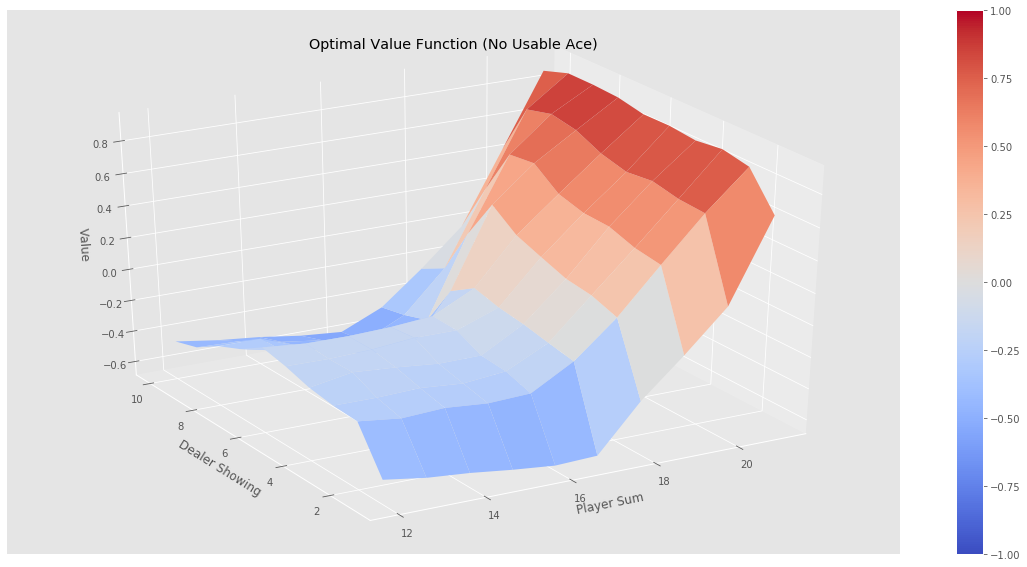

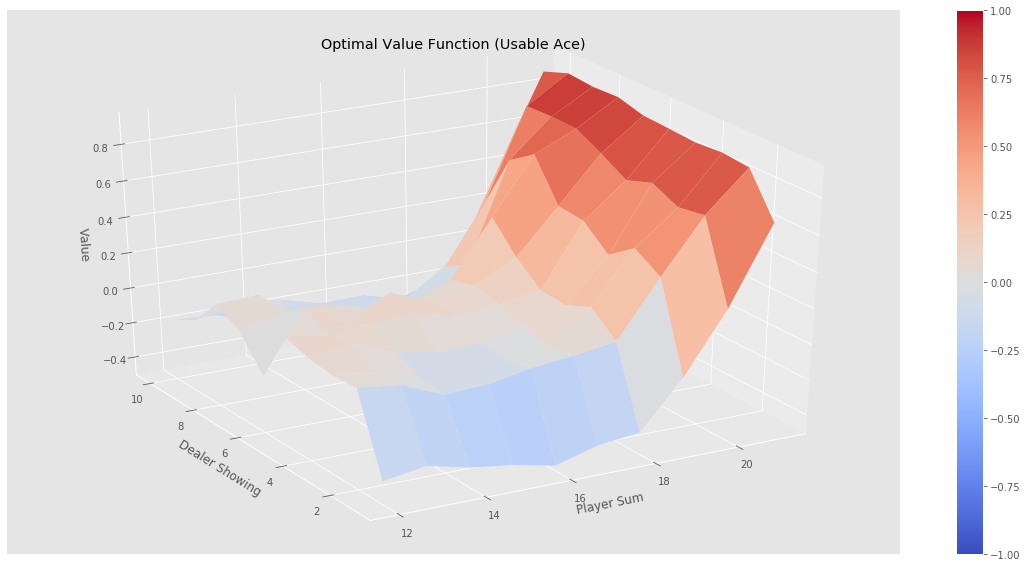

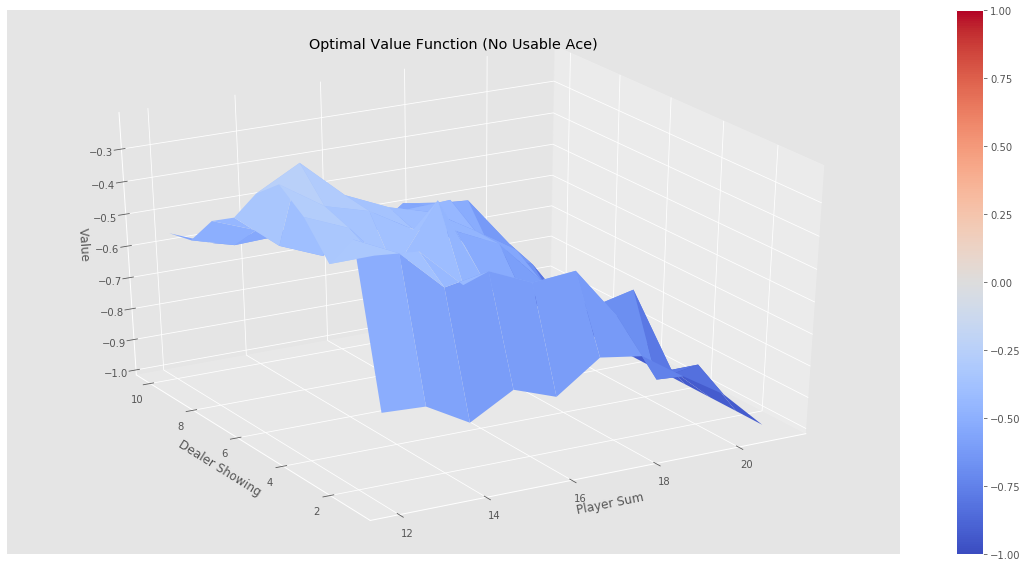

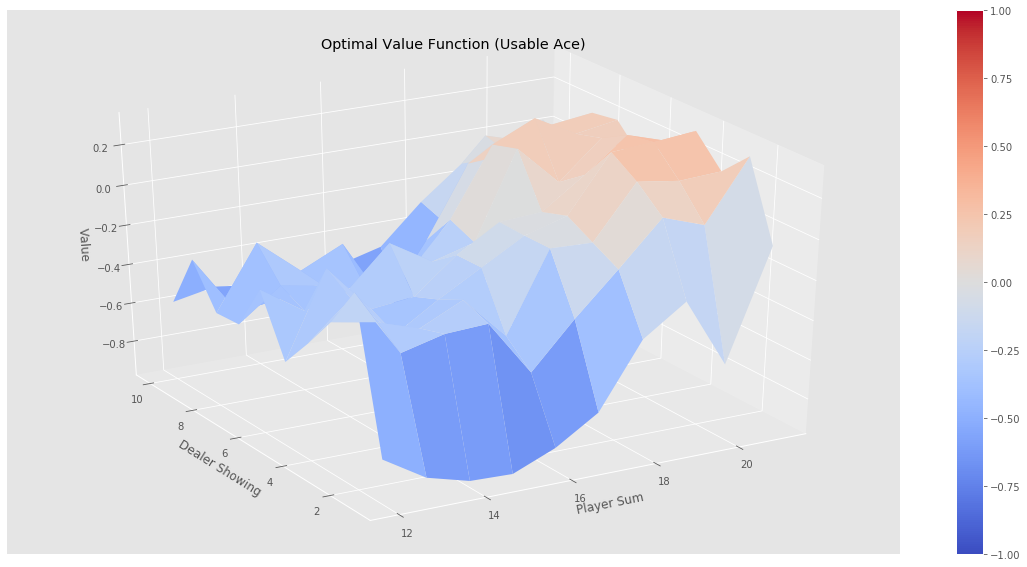

In [9]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

for state, actions in Q.items():
    action_value = np.min(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

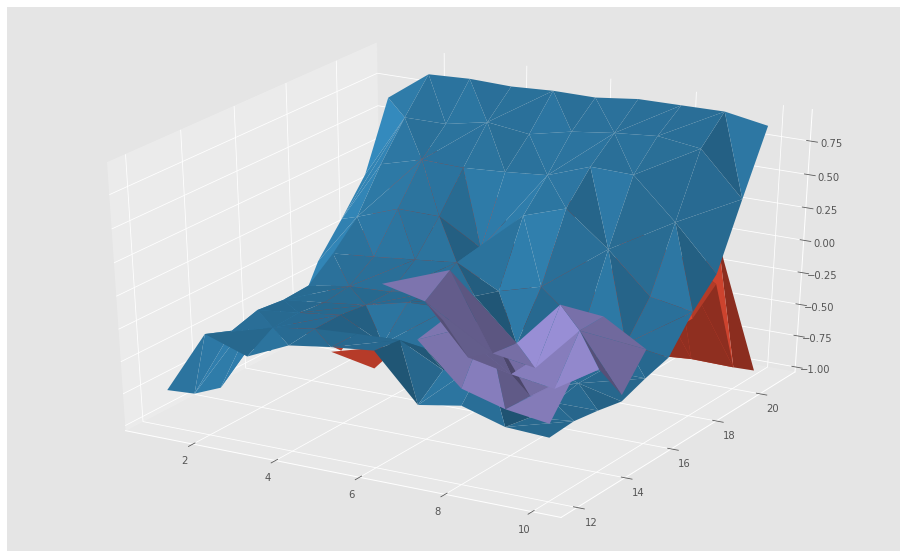

In [20]:
import matplotlib.pyplot as plt
Y = np.array([s[0] for s, a in Q.items()])
X = np.array([s[1] for s, a in Q.items()])
Z = np.array([np.max(a) for s, a in Q.items()])
Z2 = np.array([a[0] for s, a in Q.items()])
Z1 = np.array([a[1] for s, a in Q.items()])

# X, Y = np.meshgrid(X, Y)
fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')
# ax.plot_trisurf(X,Y,Z0)
# ax.plot_trisurf(X,Y,Z1)

ax.plot_trisurf(X,Y,np.where(Z1<Z2,Z1,np.nan))
ax.plot_trisurf(X,Y,Z2)
ax.plot_trisurf(X,Y,np.where(Z1>=Z2,Z1,np.nan))

In [12]:
Y = np.array([s[0] for s, a in Q.items()])
X = np.array([s[1] for s, a in Q.items()])
Z = np.array([np.max(a) for s, a in Q.items()])
Z0 = np.array([a[0] for s, a in Q.items()])
Z1 = np.array([a[1] for s, a in Q.items()])